In [1]:

import datetime
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import datetime
import numpy as np
import requests
from functools import reduce
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("df_combined.csv", index_col=False)

In [3]:
df = df.iloc[:, 1:]
df.set_index('date', inplace=True)

In [4]:
df

,bond_yield_1_yr,bond_yield_5_yr,bond_yield_10_yr,us_funds_rate,cpi_yoy,production_yoy,v39050,v39078,v39079
date,,,,,,,,,
2017-06-01,0.68,0.58,1.61,1.04,1.006945,7.074822,0.4987,0.75,0.50
2017-07-01,0.74,0.74,1.96,1.15,1.163647,4.475888,0.4970,0.75,0.50
2017-08-01,0.74,0.70,1.84,1.16,1.398626,2.618871,0.7475,1.00,0.75
2017-09-01,1.01,0.83,2.13,1.15,1.552801,1.699856,0.7588,1.00,0.75
2017-10-01,0.90,0.76,2.04,1.15,1.394292,1.557148,0.9693,1.25,1.00
...,...,...,...,...,...,...,...,...,...
2024-12-01,3.14,1.54,3.29,4.48,1.831979,-0.105260,3.7512,4.00,3.75
2025-01-01,2.96,1.45,3.18,4.33,1.895142,0.143734,3.2987,3.50,3.25
2025-02-01,2.84,1.33,2.98,4.33,2.644828,0.000000,3.0080,3.25,3.00


In [5]:
df.index = pd.DatetimeIndex(df.index, freq='MS')


In [6]:
column_feature=['bond_yield_1_yr','bond_yield_5_yr','bond_yield_10_yr','us_funds_rate','cpi_yoy','production_yoy']
column_target='v39078'

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

# Check stationarity of v39078
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is non-stationary")


In [8]:
adf_test(df[column_target])

ADF Statistic: -1.7626495158030924
p-value: 0.39915640482640985
Critical Values: {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Series is non-stationary


In [9]:
df['rate_diff'] = df[column_target].diff().dropna()
print("\nADF Test for differenced rate:")
adf_test(df['rate_diff'].dropna())


ADF Test for differenced rate:
ADF Statistic: -2.7376807593364987
p-value: 0.06774171833444405
Critical Values: {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Series is non-stationary


In [10]:
df['rate_diff_2'] = df['rate_diff'].diff()
adf_test(df['rate_diff_2'].dropna())

ADF Statistic: -13.889323433641497
p-value: 6.008227403497255e-26
Critical Values: {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Series is stationary


In [11]:
train_size = int(len(df) * 0.85)
df_train, df_test = df[:train_size], df[train_size:]

In [12]:
print(f"Training period: {df_train.index[0].date()} to {df_train.index[-1].date()}")
print(f"Testing period: {df_test.index[0].date()} to {df_test.index[-1].date()}")

Training period: 2017-06-01 to 2024-01-01
Testing period: 2024-02-01 to 2025-04-01


In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

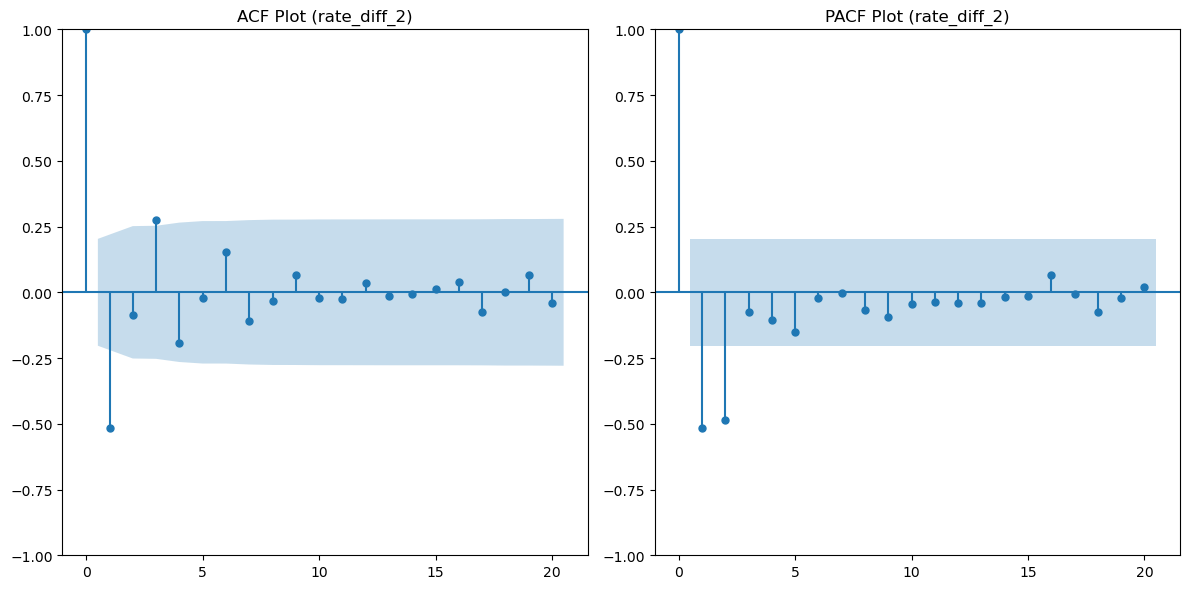

In [14]:
# Plot ACF and PACF for the second differenced series
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(121)
plot_acf(df['rate_diff_2'].dropna(), lags=20, ax=plt.gca())
plt.title('ACF Plot (rate_diff_2)')

# PACF plot
plt.subplot(122)
plot_pacf(df['rate_diff_2'].dropna(), lags=20, ax=plt.gca())
plt.title('PACF Plot (rate_diff_2)')

plt.tight_layout()
plt.show()

In [15]:
# using Arima first

In [16]:
# choose Arima parameters
p = 2 #(from PACF) Autoregressive order (AR) 	Number of past values used in the model
d = 2 #(from ADF test)  	Differencing order (I)	Number of times the data is differenced to make it stationary
q = 1 #(from ACF) Moving Average order (MA) 	Number of past forecast errors used in the model



In [17]:
# Fit ARIMAX model with order (2,2,1)
model_arima = ARIMA(df_train[column_target], exog=df_train[column_feature], order=(2,2,1))
model_arima_fit = model_arima.fit()

C:\Users\liuliu\anaconda3\envs\invest_agent\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 v39078   No. Observations:                   80
Model:                 ARIMA(2, 2, 1)   Log Likelihood                  28.936
Date:                Fri, 16 May 2025   AIC                            -37.871
Time:                        05:02:47   BIC                            -14.304
Sample:                    06-01-2017   HQIC                           -28.437
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
bond_yield_1_yr     -0.1022      0.146     -0.699      0.485      -0.389       0.184
bond_yield_5_yr      0.6471      0.165      3.922      0.000       0.324       0.971
bond_yield_10_yr    -0.3684 

In [19]:
#These features have high P value, not significant
#bond_yield_1_yr , cpi_yoy    , production_yoy , ar.L1 ,ar.L2 ,ma.L1  

column_feature_new=['bond_yield_5_yr', 'bond_yield_10_yr', 'us_funds_rate']
# Fit ARIMAX model with order (2,2,1)
model_arima = ARIMA(df_train[column_target], exog=df_train[column_feature_new], order=(2,2,1))
model_arima_fit = model_arima.fit()

C:\Users\liuliu\anaconda3\envs\invest_agent\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 v39078   No. Observations:                   80
Model:                 ARIMA(2, 2, 1)   Log Likelihood                  26.485
Date:                Fri, 16 May 2025   AIC                            -38.969
Time:                        05:02:47   BIC                            -22.472
Sample:                    06-01-2017   HQIC                           -32.365
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
bond_yield_5_yr      0.5709      0.118      4.823      0.000       0.339       0.803
bond_yield_10_yr    -0.3132      0.126     -2.493      0.013      -0.559      -0.067
us_funds_rate        0.8650 

In [21]:
# Step 7: Forecast
forecast_steps = len(df_test)
forecast = model_arima_fit.forecast(steps=forecast_steps, exog=df_test[column_feature_new])

In [22]:
rmse = np.sqrt(mean_squared_error(df_test[column_target], forecast))
print(f'RMSE: {rmse}')

RMSE: 0.7552663494034696


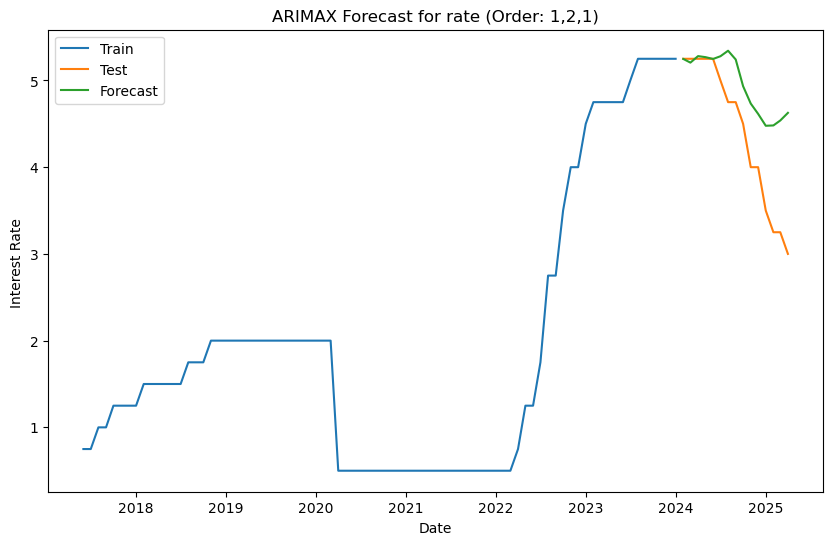

In [23]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train[column_target], label='Train')
plt.plot(df_test.index, df_test[column_target], label='Test')
plt.plot(df_test.index, forecast, label='Forecast')
plt.title('ARIMAX Forecast for rate (Order: 1,2,1)')
plt.xlabel('Date')
plt.ylabel('Interest Rate ')
plt.legend()
plt.show()

In [24]:
model_arima = ARIMA(df[column_target], exog=df[column_feature_new], order=(2,2,1))
model_arima_fit = model_arima.fit()

In [25]:

future_exog = df[column_feature_new].iloc[-1:].copy()
# Repeat the last row 6 times while keeping it as a DataFrame
future_exog = pd.DataFrame(
    np.repeat(future_exog.values, 6, axis=0),
    columns=future_exog.columns,
    index=pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')
)
future_exog

,bond_yield_5_yr,bond_yield_10_yr,us_funds_rate
2025-05-01,1.6,3.07,4.33
2025-06-01,1.6,3.07,4.33
2025-07-01,1.6,3.07,4.33
2025-08-01,1.6,3.07,4.33
2025-09-01,1.6,3.07,4.33
2025-10-01,1.6,3.07,4.33


In [26]:
future_forecast = model_arima_fit.forecast(steps=6, exog=future_exog)
future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')
future_series = pd.Series(future_forecast, index=future_dates)
print("\nFuture Forecast for v39078 (6 months ahead):")
print(future_series)


Future Forecast for v39078 (6 months ahead):
2025-05-01    2.958855
2025-06-01    2.889362
2025-07-01    2.761965
2025-08-01    2.660640
2025-09-01    2.564579
2025-10-01    2.460495
Freq: MS, Name: predicted_mean, dtype: float64


In [27]:
future_exog['yhat']=future_series
future_exog['model']='Arima'
future_exog['type']='future'
future_exog['v39078']=None

df_output_test=df_test[['bond_yield_5_yr','bond_yield_10_yr','us_funds_rate']]
df_output_test['yhat']=forecast
df_output_test['model']='Arima'
df_output_test['type']='test'


In [28]:
df_orig=df[['bond_yield_5_yr','bond_yield_10_yr','us_funds_rate','v39078']].copy()
df_orig=df_orig.merge(df_output_test[['yhat','model','type']],  how='left', left_index=True, right_index=True)
union_df = pd.concat([df_orig,future_exog ])

In [29]:
union_df['model']='Arima'
union_df['type']=union_df['type'].fillna('train')

In [30]:
union_df.to_csv("model_forecast_arima.csv",index_label='date')